In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import requests

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold

import optuna

import lightgbm as lgb

In [17]:
date = "18112022"
reu = "R1"
course = "C6"

In [20]:
r_net = requests.get(f"https://online.turfinfo.api.pmu.fr/rest/client/61/programme/{date}/{reu}/{course}/combinaisons?specialisation=INTERNET")
rjson_net = r_net.json()
combi_net = rjson_net["combinaisons"]

r_all = requests.get(f"https://online.turfinfo.api.pmu.fr/rest/client/61/programme/{date}/{reu}/{course}/combinaisons")
rjson_all = r_all.json()
combi_all = rjson_all["combinaisons"]

sg_net = next(item for item in combi_net if item["pariType"] == "E_SIMPLE_GAGNANT")
total_sg_net = sg_net["totalEnjeu"]
ordre_net = [enjeu['combinaison'] for enjeu in sg_net['listeCombinaisons']]
enjeux_net = [enjeu['totalEnjeu'] for enjeu in sg_net['listeCombinaisons']]
perc_net = np.array([enjeu['totalEnjeu'] / total_sg_net for enjeu in sg_net['listeCombinaisons']])
print(total_sg_net)


dict_proba_net = {num[0]: enjeu for num,enjeu in zip(ordre_net,perc_net)}

n = len(dict_proba_net)

H_net = np.zeros((n,n))
in_sort = sorted(list(dict_proba_net))
for i in range(len(dict_proba_net)):
    for j in range(len(dict_proba_net)):
        if i!=j:
            H_net[i,j] = dict_proba_net[in_sort[i]] * dict_proba_net[in_sort[j]]**(0.76) / sum(perc_net**(0.76))

sum_proba_net = [sum(H_net[i,:]) for i in range(len(H_net))]

sg_all = next(item for item in combi_all if item["pariType"] == "SIMPLE_GAGNANT")
total_sg_all = sg_all["totalEnjeu"]
ordre_all = [enjeu['combinaison'] for enjeu in sg_all['listeCombinaisons']]
enjeux_all = [enjeu['totalEnjeu'] for enjeu in sg_all['listeCombinaisons']]
perc_all = np.array([enjeu['totalEnjeu'] / total_sg_all for enjeu in sg_all['listeCombinaisons']])
print(total_sg_all)

dict_proba_all = {num[0]: enjeu for num,enjeu in zip(ordre_all,perc_all)}

H_all = np.zeros((n,n))
in_sort = sorted(list(dict_proba_all))
for i in range(len(dict_proba_all)):
    for j in range(len(dict_proba_all)):
        if i!=j:
            H_all[i,j] = dict_proba_all[in_sort[i]] * dict_proba_all[in_sort[j]]**(0.76) / sum(perc_all**(0.76))
sum_proba_all = [sum(H_all[i,:]) for i in range(len(H_all))]

df = pd.DataFrame(H_all, columns=sorted(list(dict_proba_all)))
df.index = sorted(list(dict_proba_all))
df["sum_all"] = sum_proba_all
df["sum_net"] = sum_proba_net

df["rapport_all"] = 1 / df["sum_all"]
df["rapport_net"] = 1 / df["sum_net"]

df["rapport_diff"] = df["rapport_net"] - df["rapport_all"]

df[["sum_all","sum_net", "rapport_all", "rapport_net", "rapport_diff"]].sort_values("sum_all")

3360700
13609637


sum_all   sum_net  rapport_all  rapport_net  rapport_diff
12  0.010879  0.013399    91.922740    74.630609    -17.292131
5   0.011500  0.012887    86.959494    77.596250     -9.363244
9   0.013825  0.012887    72.330845    77.596250      5.265406
4   0.014686  0.013541    68.092978    73.847312      5.754334
2   0.016150  0.016006    61.918721    62.477083      0.558363
7   0.016449  0.022085    60.792691    45.279531    -15.513160
13  0.017810  0.019547    56.148692    51.158351     -4.990341
11  0.044943  0.047637    22.250470    20.991979     -1.258491
8   0.055609  0.070237    17.982627    14.237453     -3.745174
10  0.068067  0.083699    14.691350    11.947585     -2.743765
6   0.072164  0.073008    13.857232    13.697075     -0.160157
15  0.328432  0.326055     3.044770     3.066969      0.022199

In [16]:
df

1         2         3         4         5         6         7  \
1   0.000000  0.002916  0.003334  0.002879  0.027527  0.007896  0.003420   
2   0.001984  0.000000  0.000670  0.000579  0.005533  0.001587  0.000687   
3   0.002366  0.000699  0.000000  0.000690  0.006597  0.001892  0.000820   
4   0.001951  0.000576  0.000659  0.000000  0.005439  0.001560  0.000676   
5   0.038054  0.011242  0.012850  0.011096  0.000000  0.030439  0.013183   
6   0.007359  0.002174  0.002485  0.002146  0.020519  0.000000  0.002549   
7   0.002447  0.000723  0.000826  0.000714  0.006823  0.001957  0.000000   
8   0.018107  0.005349  0.006114  0.005280  0.050491  0.014483  0.006273   
9   0.010638  0.003143  0.003592  0.003102  0.029663  0.008509  0.003685   
10  0.006263  0.001850  0.002115  0.001826  0.017463  0.005009  0.002170   
11  0.002578  0.000762  0.000871  0.000752  0.007189  0.002062  0.000893   
12  0.000986  0.000291  0.000333  0.000287  0.002748  0.000788  0.000341   

           8         9        10        11        12   sum_all   sum_net  \
1   0.015654  0.010449  0.006985  0.003558  0.001713  0.086332  0.104846   
2   0.003147  0.002100  0.001404  0.000715  0.000344  0.018752  0.031758   
3   0.003752  0.002504  0.001674  0.000853  0.000411  0.022258  0.018166   
4   0.003093  0.002065  0.001380  0.000703  0.000339  0.018439  0.017947   
5   0.060342  0.040278  0.026927  0.013717  0.006605  0.264734  0.247930   
6   0.011669  0.007789  0.005207  0.002652  0.001277  0.065825  0.062612   
7   0.003880  0.002590  0.001731  0.000882  0.000425  0.022999  0.026557   
8   0.000000  0.019165  0.012813  0.006527  0.003143  0.147745  0.164525   
9   0.016869  0.000000  0.007527  0.003834  0.001846  0.092409  0.083277   
10  0.009931  0.006629  0.000000  0.002257  0.001087  0.056599  0.048188   
11  0.004088  0.002729  0.001824  0.000000  0.000447  0.024195  0.024042   
12  0.001563  0.001043  0.000697  0.000355  0.000000  0.009434  0.008261   

    rapport_all  rapport_net  rapport_diff  
1     11.583224     9.537800     -2.045425  
2     53.327337    31.487668    -21.839669  
3     44.928085    55.047653     10.119568  
4     54.231671    55.719882      1.488211  
5      3.777381     4.033398      0.256018  
6     15.191725    15.971446      0.779721  
7     43.480857    37.654655     -5.826202  
8      6.768430     6.078099     -0.690331  
9     10.821410    12.008129      1.186719  
10    17.668290    20.752172      3.083882  
11    41.331192    41.593771      0.262579  
12   106.005021   121.047224     15.042204

In [149]:
features_pred = ['num',
    'tpsLastRace',
    'last_race_dist',
    'fer',
    'firstTimeFer',
    'sex',
    'age_x',
    'dist',
    'avisTrainer',
    'lastPerf',
    'meanPerf',
    'medianPerf',
    'modePerf',
    'recordAbs',
    'gain',
    'nbDiscalifieMusic',
    'nbVictoireMusic',
    'nbPlaceMusic',
    'nbArrivé',
    'nombreCourses',
    'nombreVictoires',
    'nombrePlaces',
    'nombrePlacesSecond',
    'nombrePlacesTroisieme',
    'gainsParticipant_gainsPlace',
    'gainsParticipant_gainsAnneeEnCours',
    'gainsParticipant_gainsAnneePrecedente',
    'nbCourseCouple',
    'nbVictoiresCouple',
    'nb2emeCouple',
    'nb3emeCouple',
    'txReussiteCouple',
    'dernierRapportReference_rapport',
    "dernierRapportReference_indicateurTendance",
            'nbCourseTrainer',
 'nbVictoiresTrainer',
 'nb2emeTrainer',
 'nb3emeTrainer',
 'txReussiteTrainer',
 'nbCourseTandem',
 'nbVictoiresTandem',
 'nb2emeTandem',
 'nb3emeTandem',
 'txReussiteTandem',
 'nbCourseDriver',
 'nbVictoiresDriver',
 'nb2emeDriver',
 'nb3emeDriver',
 'txReussiteDriver']

In [150]:
loaded_model = lgb.Booster(model_file="models/modelv4.txt")

In [151]:
df = pd.read_csv("data/data-2021.csv")
df["classement"] = df["classement"].apply(pd.to_numeric, errors="coerce").replace(0.,10.).fillna(10.).astype(np.int32)
df["dernierRapportReference_indicateurTendance"] = df["dernierRapportReference_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0).astype(np.int32)
df["dernierRapportDirect_indicateurTendance"] = df["dernierRapportDirect_indicateurTendance"].replace(["+", " ", "-"], [1, 0, -1]).fillna(0).astype(np.int32)

df.drop_duplicates(subset=["id", "num"], inplace=True)


df.index = np.arange(len(df))

df[["nbCourseTrainer", "nbCourseDriver"]] = df[["nbCourseTrainer", "nbCourseDriver"]].apply(pd.to_numeric, errors="coerce").fillna(0).astype(np.int32)

df["classement"] = df["classement"].replace(['DA', 'D1', 'A ',
       'D7', 'D8', 'H8', 'T ', 'G ', 'D5', 'D6', 'D', 'D3', 'D4', 'D2', 'D ',
       'G5', 'D9', 'H9', 'G4', 'R8', 'G6','G3', 'G2', 'G1','G0'], 10).fillna(10).astype(np.int32)

df["nbDiscalifieMusic"] = df["music"].apply(lambda x: x.replace("[", "").replace("]", "").split(", ").count("0"))
df["nbVictoireMusic"] = df["music"].apply(lambda x: x.replace("[", "").replace("]", "").split(", ").count("1"))
df["nbPlaceMusic"] = df["music"].apply(lambda x: sum(map( lambda j: int(j) <= 3 and int(j) > 0, x.replace("[", "").replace("]", "").split(", "))))
grouped = df.groupby("id")

print("Nombre de course:",len(df.groupby("id")))
df.tail() 

Nombre de course: 622


num              nom numCoursePMU  classement             id  \
8020   12  FOLLOW ME FLASH         R3C8           3  2021061014008   
8021   13    FORREST D'ARC         R3C8          10  2021061014008   
8022   14   FOREVER ISQUES         R3C8           2  2021061014008   
8023   15          FOSBURY         R3C8           7  2021061014008   
8024   16       FORT GALAA         R3C8          10  2021061014008   

            date                                                url  \
8020  2021-06-10  https://www.letrot.com/stats/fiche-cheval/foll...   
8021  2021-06-10  https://www.letrot.com/stats/fiche-cheval/forr...   
8022  2021-06-10  https://www.letrot.com/stats/fiche-cheval/fore...   
8023  2021-06-10  https://www.letrot.com/stats/fiche-cheval/fosb...   
8024  2021-06-10  https://www.letrot.com/stats/fiche-cheval/fort...   

      tpsLastRace  last_race_dist  fer  ...  nb3emeDriver  txReussiteDriver  \
8020            8            2200    6  ...            15                26   
8021           11            2650    0  ...            36                18   
8022           17            2575    3  ...            81                28   
8023           10            3025    3  ...           124                34   
8024           76            2200    3  ...           211                44   

      ecurie  placeCorde tauxReclamation poidsConditionMonte  nomPereMere  \
8020     NaN         NaN             NaN                 NaN          NaN   
8021     NaN         NaN             NaN                 NaN          NaN   
8022     NaN         NaN             NaN                 NaN          NaN   
8023     NaN         NaN             NaN                 NaN          NaN   
8024     NaN         NaN             NaN                 NaN          NaN   

     nbDiscalifieMusic  nbVictoireMusic  nbPlaceMusic  
8020                 3                0             1  
8021                 1                3             6  
8022                 1                5             8  
8023                 5                2             5  
8024                 6                0             0  

[5 rows x 115 columns]

In [152]:
preds = loaded_model.predict(df.loc[:][features_pred])

df["pred"] = preds
df['pred'] = df.groupby("id")["pred"].rank("dense",ascending=True).astype(int)
df['pred'] = df.groupby("id")["pred"].rank("first").astype(int)

In [153]:
len(df[["id", "date", "num","classement", "pred"]].loc[(df["pred"] == 1) & (df["classement"] == 1)]) / len(df.groupby("id"))

0.2652733118971061

7 18 36


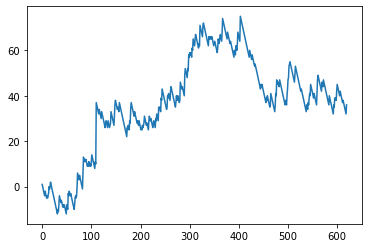

In [154]:
m_consecutive_loses = 0
m_consecutive_wins = 0

consecutive_loses = 0
consecutive_wins = 0


walk = [1]

for i, row in df.loc[df["pred"] == 1].iterrows():
    if row["classement"] != 1:
        consecutive_loses +=1
        m_consecutive_wins = max(m_consecutive_wins, consecutive_wins)
        consecutive_wins = 0
        
        walk.append(walk[-1] - 1)
    else:
        if not np.isnan(row["dernierRapportDirect_rapport"]):
            walk.append(walk[-1] + int(row["dernierRapportDirect_rapport"]))
            
        consecutive_wins += 1
        
        m_consecutive_loses = max(m_consecutive_loses, consecutive_loses)
        consecutive_loses = 0

print(m_consecutive_wins, m_consecutive_loses, walk[-1])
plt.plot(walk)

In [155]:
X = df.loc[:].loc[df["classement"] == 1]["dernierRapportDirect_rapport"].dropna().sort_values(ascending=True)
n = len(X)

prob = 0.1

cap = -1000

while cap < 0:
    xperc = int(prob * n)
    prob += 0.01
    cap = -len(df.groupby("id")) + X.iloc[:xperc].sum()
print("Proba de gagner nécessaire pour être à l'équilibre:",round(prob, 3))

Proba de gagner nécessaire pour être à l'équilibre: 0.42


In [156]:
df.loc[(df["classement"]== 1 ) & (df["pred"]== 1 )]["dernierRapportDirect_rapport"].describe()

count    162.000000
mean       3.525309
std        2.611354
min        1.200000
25%        1.900000
50%        2.850000
75%        4.300000
max       27.000000
Name: dernierRapportDirect_rapport, dtype: float64

-137.89999999999998


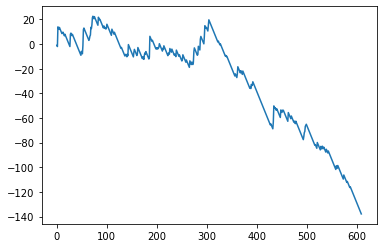

In [147]:
argent = 0
evo = []
for i,row in df.loc[df["pred"] == 1].iterrows():
    if not np.isnan(row["dernierRapportDirect_rapport"]):
        if row["classement"] == 1:
            argent += row["dernierRapportDirect_rapport"] - 1
        else:
            argent -= 1
        evo.append(argent)
            
print(argent)
plt.plot(evo)

In [180]:
today = pd.read_csv("data-2022.csv")
today[["meanReduction", "recordAbs", "maxReduction", "minReduction", "timeSinceRecord"]]

meanReduction  recordAbs  maxReduction  minReduction  timeSinceRecord
0       772.428571        748           800           748               84
1       761.666667        749           773           749               18
2       759.625000        749           779           749              135
3       762.222222        742           782           742              201
4       762.000000        748           781           748               18
..             ...        ...           ...           ...              ...
251     767.500000        731           803           731               23
252     761.722222        727           788           727               31
253     760.545455        729           802           729              130
254     756.312500        729           790           729               31
255     771.214286        728           815           728               23

[256 rows x 5 columns]

In [173]:
today["last_race_dist"]

0      2700
1      2700
2      2700
3      2700
4      2700
       ... 
895    2650
896    2675
897    2100
898    2875
899    2825
Name: last_race_dist, Length: 900, dtype: int64